<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/328b_smFISH_analysis_using_Big_FISH_multiplex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/c_uh0YelIHA

**smFISH analysis using the Big-FISH library**

This tutorial is a walkthrough of smFISH (single-molecule fluorescence in situ hybridization) analysis using the Big-FISH library. The code demonstrates various steps involved in the analysis, including image reading, normalization and filtering, spot detection, segmentation of nuclei and cells, extraction of cell-level results, and computation of features for each cell - in a multiplex dataset. <p>

By analyzing the extracted features and the spatial distribution of spots within cells, researchers can gain insights into various aspects of cellular processes, including gene expression, RNA localization, and spatial organization. These insights can contribute to understanding the functional organization of cells and uncovering potential relationships between gene expression patterns and cellular phenotypes.<p>

The "spots" in smFISH analysis refer to individual mRNA molecules that have been labeled with fluorescent probes and can be visualized as discrete signals in the images. Each spot represents the presence of a specific mRNA molecule within the cell. <p>

The brightness of a spot generally corresponds to the abundance or level of the mRNA molecule it represents. Bright spots indicate a higher concentration of the mRNA molecule, suggesting higher expression levels of the corresponding gene. Conversely, dimmer spots may indicate lower expression levels. <p>

"Clusters" refer to groups of spots that are in close proximity to each other. Clusters can arise due to various reasons, such as multiple mRNA molecules originating from the same gene or co-localization of mRNA molecules from different genes. The presence of clusters may indicate co-regulation or co-localization of specific mRNA molecules within the cell. <p>

Spots that are classified as "inside" the nucleus are localized within the nuclear boundary, indicating that the corresponding mRNA molecules are likely involved in nuclear processes, such as transcription, splicing, or RNA processing. On the other hand, spots classified as "outside" the nucleus are located in the cytoplasm, suggesting that the corresponding mRNA molecules have been transported out of the nucleus and are involved in cytoplasmic processes, such as translation. <p>

Analyzing the distribution of spots inside and outside the nucleus can provide insights into gene expression regulation and mRNA localization. For example, certain genes may exhibit preferential nuclear localization, indicating their involvement in nuclear processes. On the other hand, cytoplasmic localization may be associated with mRNA molecules that are actively being translated or are involved in cytoplasmic functions.

**Dataset / images for this exercise:** <br>
Researchers often work with fluorescence in situ hybridization (FISH) images that involve multiple channels containing spots from multiple RNA molecules. FISH techniques can be designed to target specific RNA molecules of interest using fluorescently labeled probes. Each RNA molecule can be labeled with a different fluorophore, allowing researchers to distinguish and visualize multiple RNA species simultaneously. <p>

Dataset (image) used in this exercise can be downloaded from: https://github.com/LieberInstitute/dotdotdot/blob/master/images/Mouse1.czi
<br>
The z-stack consists of 14 z slices, each 201 x 201 pixels and 4 channels: "Cy5", "DsRed" (red), "EGFP" (green), and "DAPI" (blue) in that order. Scaling is 0.31 um x 0.31 um x 0.40 um. The data was collected on ZEISS LSM700, AxioObserver microscope with plan Apochromat objective at 40x/1.3 oil DIC.
<p>

**Other datasets of use:**
<br>
This is a good reference paper that mentions a few datasets: https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-022-01669-y/MediaObjects/41592_2022_1669_MOESM1_ESM.pdf
<br>


**python environment requirements:** <br>
Big-FISH requires Python 3.6 or newer. Additionally, it has the following dependencies which should be fine if you are working on colab:
<br>
numpy (>= 1.16.0) <br>
scipy (>= 1.4.1) <br>
scikit-learn (>= 0.24.0) <br>
scikit-image (>= 0.14.2) <br>
matplotlib (>= 3.0.2) <br>
pandas (>= 0.24.0) <br>
mrc (>= 0.1.5) <p>
For segmentation purpose, two additional dependencies may be required:
<br>
tensorflow (== 2.3.0)<br>
tensorflow-addons (== 0.12.1)
<p>
Finally, pip install big-fish

In [ ]:
!pip install mrc big-fish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install czifile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.9 MB/s eta 0:00:00


# Read images
<br>
Let us start by reading images using bigfish.

In [ ]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from matplotlib import pyplot as plt
import czifile
import pandas as pd

In [ ]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [ ]:
def segment_nuclei(DAPI):
  DAPI_mip = stack.maximum_projection(DAPI)
  # Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
  model = StarDist2D.from_pretrained('2D_versatile_fluo')

  nuc_labels, nuc_details = model.predict_instances(normalize(DAPI_mip), prob_thresh=0.65)
  return DAPI_mip, nuc_labels

In [ ]:
def process_channel(input_channel, voxel_size, spot_radius):
    # Normalize and filter
    mip = stack.maximum_projection(input_channel)

    # Spot detection
    spots, threshold = detection.detect_spots(
        images=input_channel,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius
    )

    # Decompose dense regions
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=input_channel,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,
        beta=1,
        gamma=5
    )

    # Spot clustering
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=450,
        nb_min_spots=4
    )

    #Nuclei segmentation (Include cell segmentation step here on appropriate images)
    DAPI_mip, nuc_labels = segment_nuclei(DAPI)

    #Transcription sites
    spots_no_ts, foci, ts = multistack.remove_transcription_site(spots_post_clustering, clusters, nuc_labels, ndim=3)

    #we can identify objects in specific cellular compartments with the following function
    spots_in, spots_out = multistack.identify_objects_in_region(nuc_labels, spots_post_clustering, ndim=3)

    #Extract cells information (in our example, we only have nuclei)
    fov_results = multistack.extract_cell(
        cell_label=nuc_labels,
        ndim=3,
        nuc_label=nuc_labels,
        rna_coord=spots_no_ts,
        others_coord={"foci": foci, "transcription_site": ts},
        image= mip,   #for the image of the cell in 2D
        others_image={"dapi": DAPI_mip, "smfish": mip})
    print("number of nuclei identified: {0}".format(len(fov_results)))

    for i, cell_results in enumerate(fov_results):
        print("cell {0}".format(i))

        # get cell results
        cell_mask = cell_results["cell_mask"]
        cell_coord = cell_results["cell_coord"]
        nuc_mask = cell_results["nuc_mask"]
        nuc_coord = cell_results["nuc_coord"]
        rna_coord = cell_results["rna_coord"]
        foci_coord = cell_results["foci"]
        ts_coord = cell_results["transcription_site"]
        image_contrasted = cell_results["image"]
        print("\r number of rna {0}".format(len(rna_coord)))
        print("\r number of foci {0}".format(len(foci_coord)))
        print("\r number of transcription sites {0}".format(len(ts_coord)))

    df = multistack.summarize_extraction_results(fov_results, ndim=3)



    return df







In [ ]:
# Load input image
path_input = "/content/drive/MyDrive/ColabNotebooks/data/smFish/Mouse-multiplex/input"
path_output = "/content/drive/MyDrive/ColabNotebooks/data/smFish/Mouse-multiplex/output"
input_image = czifile.imread(os.path.join(path_input, 'Mouse1.czi'))

# Extract channels from the input image
Cy5 = input_image[0, 0, 0, 0, :, :, :, 0]
DsRed = input_image[0, 0, 1, 0, :, :, :, 0]
EGFP = input_image[0, 0, 2, 0, :, :, :, 0]
DAPI = input_image[0, 0, 3, 0, :, :, :, 0]

# Define voxel size and spot radius
voxel_size = (400, 310, 310)
spot_radius = (450, 360, 360)



Plot MIP images - just for visual purposes

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 10s 10s/step


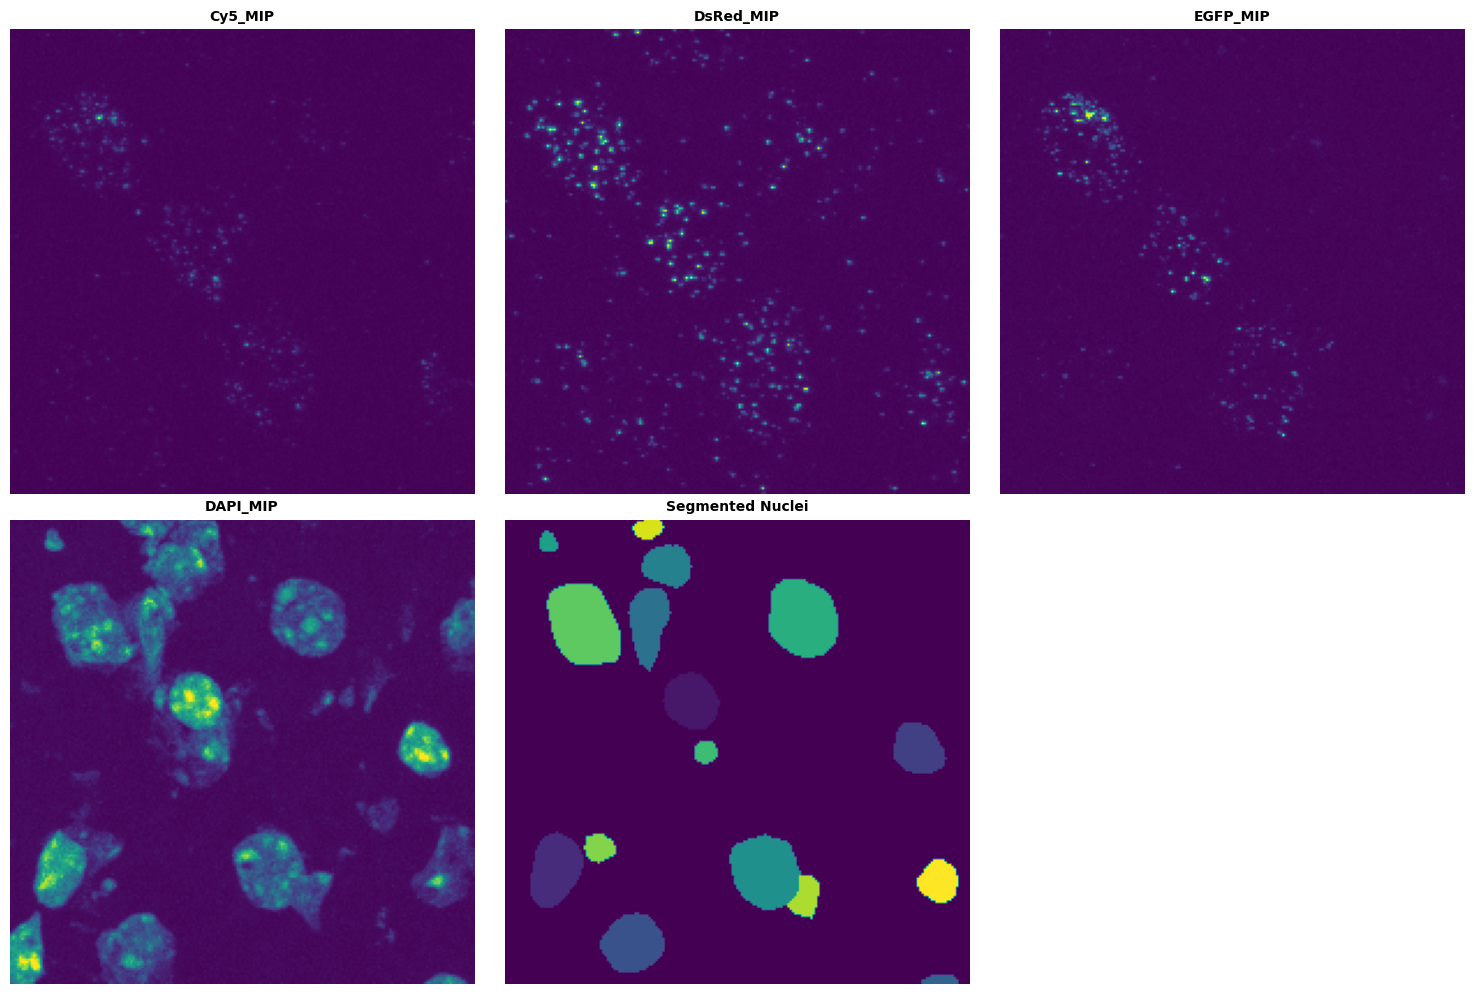

In [ ]:
Cy5_MIP = stack.maximum_projection(Cy5)
DsRed_MIP = stack.maximum_projection(DsRed)
EGFP_MIP = stack.maximum_projection(EGFP)
DAPI_MIP = stack.maximum_projection(DAPI)
nuc_labels = segment_nuclei(DAPI)[1]
images_for_plot = [Cy5_MIP, DsRed_MIP, EGFP_MIP, DAPI_MIP, nuc_labels]
titles = ["Cy5_MIP", "DsRed_MIP", "EGFP_MIP", "DAPI_MIP", "Segmented Nuclei"]
plot.plot_images(images_for_plot, titles=titles)

In [ ]:
Cy5_df = process_channel(Cy5, voxel_size, spot_radius)
DsRed_df = process_channel(DsRed, voxel_size, spot_radius)
EGFP_df = process_channel(EGFP, voxel_size, spot_radius)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 0s 193ms/step
number of nuclei identified: 14
cell 0
 number of rna 18
 number of foci 0
 number of transcription sites 0
cell 1
 number of rna 10
 number of foci 0
 number of transcription sites 0
cell 2
 number of rna 3
 number of foci 0
 number of transcription sites 0
cell 3
 number of rna 11
 number of foci 0
 number of transcription sites 0
cell 4
 number of rna 6
 number of foci 0
 number of transcription sites 0
cell 5
 number of rna 3
 number of foci 0
 number of transcription sites 0
cell 6
 number of rna 38
 number of foci 0
 number of transcription sites 2
cell 7
 number of rna 0
 number of foci 0
 number of transcription sites 0
cell 8
 number of rna 12
 number of foci 0
 number of transcription sites 0
cell 9
 number of rna 3
 number of

In [ ]:
# Add a new column to each DataFrame indicating the channel
Cy5_df['channel'] = 'Cy5'
DsRed_df['channel'] = 'DsRed'
EGFP_df['channel'] = 'EGFP'
# Concatenate the three DataFrames vertically
combined_df = pd.concat([Cy5_df, DsRed_df, EGFP_df], ignore_index=True)

#Since in our example we have no cells, let us drop irrelevant columns
combined_df = combined_df.drop(['nb_rna_out_nuc', 'nb_foci', 'nb_transcription_site', 'nb_rna_in_nuc'], axis=1)

path = os.path.join(path_output, "combined_results.csv")
combined_df.to_csv(path)


In [ ]:
#Print random rows
print(combined_df.sample(n=10))

    cell_id  cell_area  nuc_area  nb_rna channel
39       13        131       131       3    EGFP
28        1        458       458      13    EGFP
7         9         56        56       0     Cy5
32        6        434       434       3    EGFP
2         3        390       390       3     Cy5
36       10        819       819       7    EGFP
11       13        131       131       2     Cy5
14        1        458       458      13   DsRed
20        8        759       759      34   DsRed
30        3        390       390       1    EGFP


# Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

**Bar Plot: Visualize the total number of RNA in each channel.**
<p>
This refers to the sum or aggregate of all RNA counts in each channel. It represents the overall quantity of RNA detected in each channel. By calculating the total RNA count per channel, you can compare the relative abundance of RNA across different channels and get an idea of the total expression level for each channel.

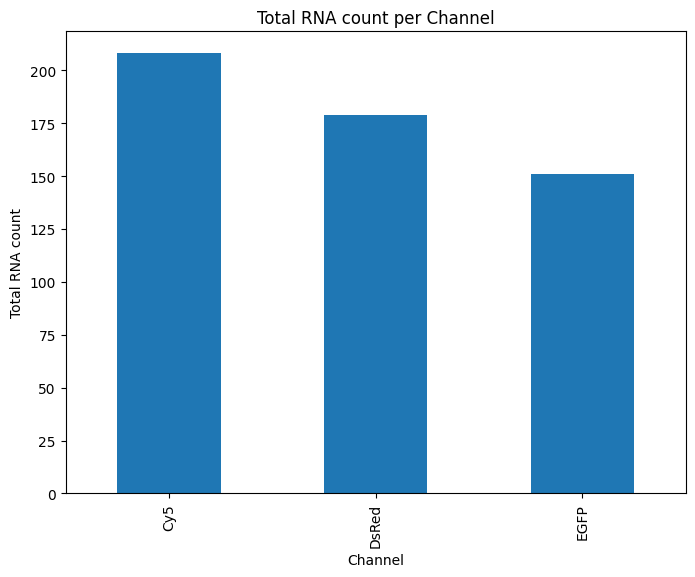

In [ ]:
plt.figure(figsize=(8, 6))
combined_df.groupby('channel')['nb_rna'].sum().plot(kind='bar')
plt.xlabel('Channel')
plt.ylabel('Total RNA count')
plt.title('Total RNA count per Channel')
plt.show()

**Box Plot: Compare the distribution of RNA counts across different channels.**
<p>
This refers to the pattern or spread of RNA counts within each channel. It provides insights into the variability and range of RNA counts observed within a specific channel. The distribution can be visualized using various plots, such as histograms, box plots, or violin plots. These plots show the frequency or density of RNA counts at different levels and allow you to understand the spread, central tendency, and potential outliers in the data.

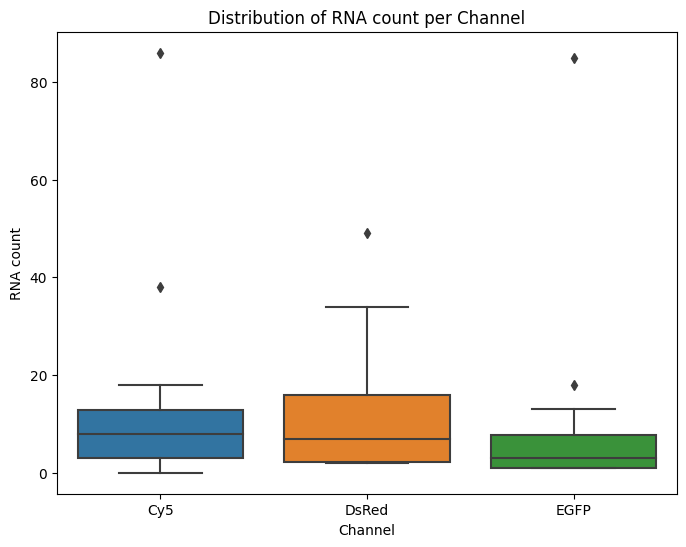

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='channel', y='nb_rna')
plt.xlabel('Channel')
plt.ylabel('RNA count')
plt.title('Distribution of RNA count per Channel')
plt.show()

For Cy5: The lowest RNA count is 0 --> some nuclei have no detectable RNA. Median is about 10. Two values are outliers (about 40 and 90), so there are two nuclei with very high RNA counts in this channel.

**Violin Plot: Visualize the distribution of RNA counts in each channel.**

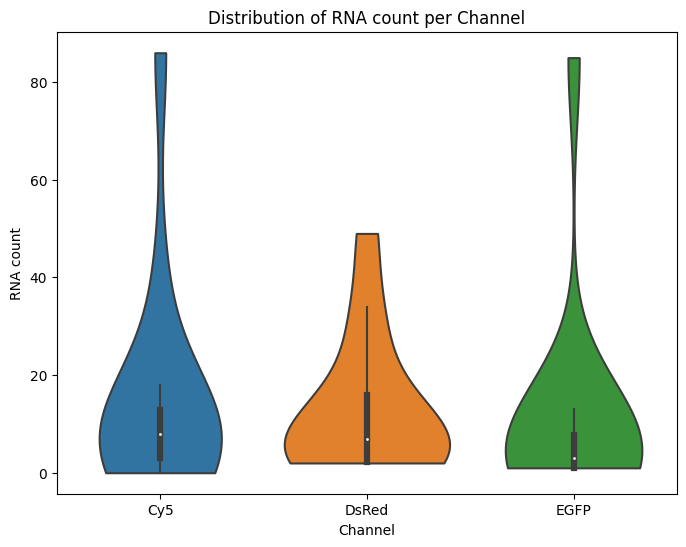

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=combined_df, x='channel', y='nb_rna', cut=0)
plt.xlabel('Channel')
plt.ylabel('RNA count')
plt.title('Distribution of RNA count per Channel')
plt.show()


**Scatter Plot: Explore the relationship between nucleus area and RNA count in each channel.** <p>
You can analyze how the RNA count varies with respect to different nucleus sizes. This can help identify any trends or patterns, such as an increase or decrease in RNA count as nucleus area changes. For example, if you notice a positive correlation, it suggests that larger nuclei tend to have higher RNA counts. You can also study any outliers or unusual data points where the RNA count deviates significantly from the general trend. These outliers could represent nuclei with exceptional RNA content compared to their respective nucleus sizes.

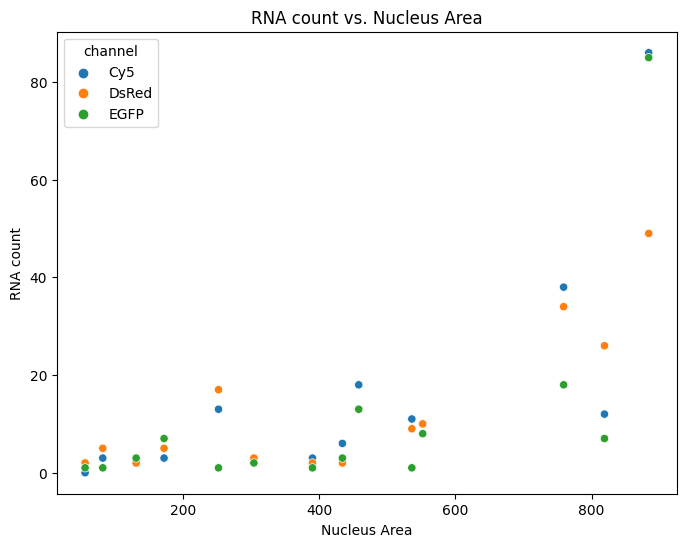

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x='nuc_area', y='nb_rna', hue='channel')
plt.xlabel('Nucleus Area')
plt.ylabel('RNA count')
plt.title('RNA count vs. Nucleus Area')
plt.show()


**Histogram: Examine the distribution of RNA counts within each channel.** <p>
It allows you to compare the relative levels of RNA for different channels and assess which channels have higher or lower RNA counts. By comparing the RNA counts across channels, you can identify any differences in RNA expression levels between the channels. This can provide insights into the relative abundance of different RNA species or the differential expression of genes or transcripts across channels.

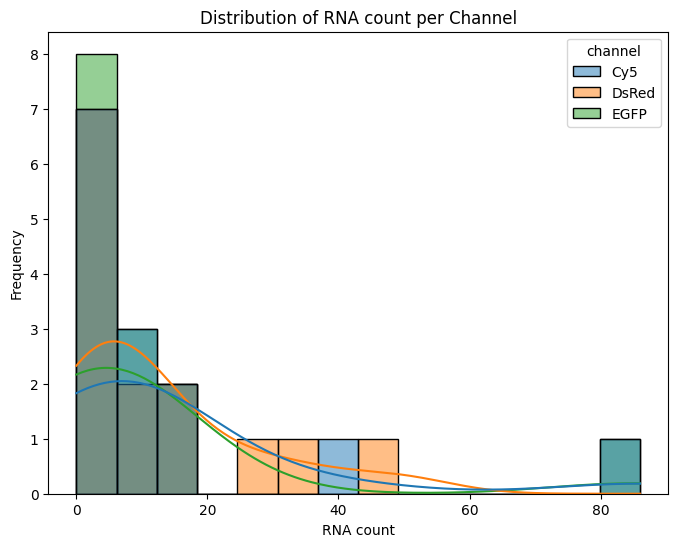

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=combined_df, x='nb_rna', hue='channel', kde=True)
plt.xlabel('RNA count')
plt.ylabel('Frequency')
plt.title('Distribution of RNA count per Channel')
plt.show()


**RNA Count Heatmap** <p>
Visualize the RNA count across different nuclei and channels. This plot can help identify patterns, clusters, or correlations in RNA expression across the different channels.

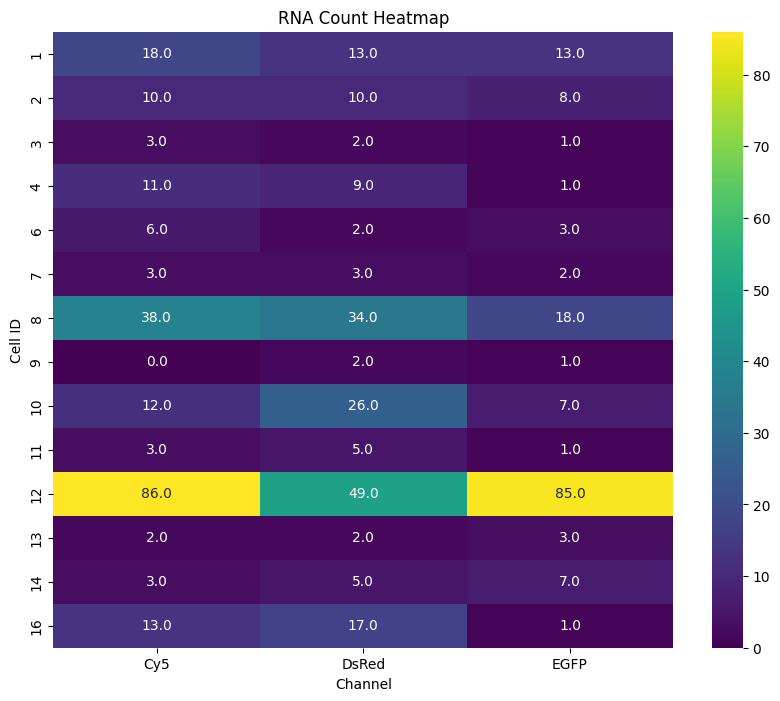

In [ ]:
heatmap_data = combined_df.pivot(index='cell_id', columns='channel', values='nb_rna')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f")
plt.title('RNA Count Heatmap')
plt.xlabel('Channel')
plt.ylabel('Cell ID')
plt.show()